In [2]:
import pandas as pd
import numpy as np
from scipy.spatial import Delaunay, distance_matrix
import networkx as nx
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import csv
from geopy.distance import geodesic

In [1]:
def load_bridge_data(csv_file_path):
    """Load bridge sensor data from CSV file"""
    df = pd.read_csv(csv_file_path)
    return df

In [3]:
def calculate_3d_distance(coord1, coord2):
    """Calculate 3D distance considering lat, lon, and altitude"""
    # Calculate horizontal distance using geodesic (more accurate for lat/lon)
    horizontal_dist = geodesic((coord1[0], coord1[1]), (coord2[0], coord2[1])).meters
    
    # Calculate vertical distance
    vertical_dist = abs(coord1[2] - coord2[2])
    
    # Calculate 3D Euclidean distance
    distance_3d = np.sqrt(horizontal_dist**2 + vertical_dist**2)
    
    return distance_3d

In [4]:
def get_stiffness_value(src_type, tgt_type, distance_m):
    """
    Get stiffness value based on structural element types and distance
    pier: 1.2, girder: 1.0, pylon: 1.5, ground: 0.8
    """

    type_stiffness = {
        'pier': 1.2,
        'girder': 1.0, 
        'pylon': 1.5,
        'ground': 0.8
    }
    

    if ('pier' in [src_type, tgt_type]) and ('girder' in [src_type, tgt_type]):
        return 1.1  
    elif ('pylon' in [src_type, tgt_type]) and ('girder' in [src_type, tgt_type]):
        return 1.3  
    

    if src_type == tgt_type:
        base_stiffness = type_stiffness.get(src_type, 1.0)

        distance_factor = max(0.5, 1.0 - (distance_m / 500.0)) 
        return round(base_stiffness * distance_factor, 2)
    

    src_stiff = type_stiffness.get(src_type, 1.0)
    tgt_stiff = type_stiffness.get(tgt_type, 1.0)
    return round((src_stiff + tgt_stiff) / 2, 2)

In [5]:
def create_delaunay_edges(df, max_distance=None, filter_long_edges=True):
    """Create edges using Delaunay Triangulation with optional distance filtering"""

    ref_lat = df['latitude'].mean()
    ref_lon = df['longitude'].mean()
    

    coords_2d = []
    for _, row in df.iterrows():
        x = geodesic((ref_lat, ref_lon), (ref_lat, row['longitude'])).meters
        if row['longitude'] < ref_lon:
            x = -x
        y = geodesic((ref_lat, ref_lon), (row['latitude'], ref_lon)).meters
        if row['latitude'] < ref_lat:
            y = -y
        coords_2d.append([x, y])
    
    coords_2d = np.array(coords_2d)
    node_ids = df['node_id'].tolist()
    
    print(f"\nCreating Delaunay triangulation for {len(df)} sensors...")
    print(f"Coordinate range: X={coords_2d[:, 0].min():.1f} to {coords_2d[:, 0].max():.1f}m")
    print(f"Coordinate range: Y={coords_2d[:, 1].min():.1f} to {coords_2d[:, 1].max():.1f}m")
    
    # Create Delaunay triangulation
    tri = Delaunay(coords_2d)
    
    print(f"Delaunay triangulation created with {len(tri.simplices)} triangles")
    
    # Extract edges from triangles
    edge_info = []
    edges_set = set()
    
    # Get actual 3D coordinates for distance calculations
    coords_3d = df[['latitude', 'longitude', 'altitude_m']].values
    
    for simplex in tri.simplices:
        # Each simplex (triangle) has 3 vertices, creating 3 edges
        for i in range(3):
            v1_idx = simplex[i]
            v2_idx = simplex[(i + 1) % 3]
            
            src_id = node_ids[v1_idx]
            tgt_id = node_ids[v2_idx]
            src_type = df.iloc[v1_idx]['type']
            tgt_type = df.iloc[v2_idx]['type']
            
            # Create sorted tuple to avoid duplicate edges
            edge = tuple(sorted((src_id, tgt_id)))
            if edge not in edges_set:
                # Calculate actual 3D distance
                distance = calculate_3d_distance(coords_3d[v1_idx], coords_3d[v2_idx])
                
                # Optional: filter out very long edges
                if filter_long_edges and max_distance and distance > max_distance:
                    continue
                
                edges_set.add(edge)
                
                # Determine edge type
                if src_type == tgt_type:
                    edge_type = src_type
                else:
                    edge_type = "support"  # All cross-type connections are support
                
                # Get custom stiffness value
                stiffness = get_stiffness_value(src_type, tgt_type, distance)
                
                edge_info.append({
                    'source': edge[0],
                    'target': edge[1],
                    'type': edge_type,
                    'stiffness': stiffness,
                    'distance_m': round(distance, 2),
                    'src_type': src_type,
                    'tgt_type': tgt_type
                })
    
    print(f"Generated {len(edge_info)} unique edges from triangulation")
    
    if filter_long_edges and max_distance:
        print(f"Applied distance filter: max_distance = {max_distance}m")
    
    return edge_info, tri

In [6]:
def create_constrained_delaunay_edges(df, structural_constraints=True):
    """Create Delaunay edges with structural engineering constraints"""
    # First create basic Delaunay triangulation
    edge_info, tri = create_delaunay_edges(df, filter_long_edges=False)
    
    if not structural_constraints:
        return edge_info, tri
    
    print("\nApplying structural engineering constraints...")
    
    # Analyze edge lengths by type
    distances_by_type = {}
    for edge in edge_info:
        edge_type = edge['type']
        if edge_type not in distances_by_type:
            distances_by_type[edge_type] = []
        distances_by_type[edge_type].append(edge['distance_m'])
    
    # Set reasonable maximum distances for each connection type
    max_distances = {}
    for edge_type, distances in distances_by_type.items():
        distances = np.array(distances)
        # Use mean + 2*std or 95th percentile, whichever is smaller
        threshold1 = np.mean(distances) + 2 * np.std(distances)
        threshold2 = np.percentile(distances, 85)  # More conservative for bridge structures
        max_distances[edge_type] = min(threshold1, threshold2)
        print(f"  {edge_type} connections: max distance = {max_distances[edge_type]:.1f}m")
    
    # Filter edges based on structural constraints
    filtered_edges = []
    for edge in edge_info:
        edge_type = edge['type']
        distance = edge['distance_m']
        
        # Special rules for bridge structures
        if edge_type == 'support':
            # Support connections are critical - be more lenient
            max_dist = max_distances[edge_type] * 1.2
        elif edge_type == 'ground':
            # Ground connections can be longer (foundation network)
            max_dist = max_distances[edge_type] * 1.5
        else:
            max_dist = max_distances[edge_type]
        
        if distance <= max_dist:
            filtered_edges.append(edge)
        else:
            print(f"    Filtered out long {edge_type} edge: {edge['source']}-{edge['target']} ({distance:.1f}m)")
    
    print(f"Kept {len(filtered_edges)} edges after structural filtering")
    return filtered_edges, tri

In [7]:
def analyze_connections(df, edges):
    """Analyze the types of connections created"""
    print(f"\n=== Connection Analysis ===")
    
    # Count connections by type
    connection_counts = {}
    for edge in edges:
        edge_type = edge['type']
        connection_counts[edge_type] = connection_counts.get(edge_type, 0) + 1
    
    print("Connection types:")
    for conn_type, count in sorted(connection_counts.items()):
        avg_stiffness = np.mean([e['stiffness'] for e in edges if e['type'] == conn_type])
        avg_distance = np.mean([e['distance_m'] for e in edges if e['type'] == conn_type])
        print(f"  {conn_type}: {count} edges (avg stiffness: {avg_stiffness:.2f}, avg distance: {avg_distance:.1f}m)")
    
    # Check for important structural connections
    support_connections = [e for e in edges if e['type'] == 'support']
    print(f"\nImportant structural connections:")
    print(f"  Support connections (all cross-type): {len(support_connections)}")
    
    if support_connections:
        print("  Examples of support connections:")
        for conn in support_connections[:8]:  # Show first 8
            print(f"    {conn['source']} ({conn['src_type']}) ↔ {conn['target']} ({conn['tgt_type']}) - {conn['distance_m']:.1f}m")

In [8]:
def save_edges_csv(edges, filename='bridge_edges_delaunay.csv'):
    """Save edges to CSV file"""
    with open(filename, 'w', newline='') as f:
        writer = csv.writer(f)
        writer.writerow(['source', 'target', 'type', 'stiffness', 'distance_m', 'src_type', 'tgt_type'])
        for edge in edges:
            writer.writerow([edge['source'], edge['target'], edge['type'], 
                           edge['stiffness'], edge['distance_m'], edge['src_type'], edge['tgt_type']])
    print(f"Edges saved to {filename}")

In [9]:
def create_networkx_graph(df, edges):
    """Create NetworkX graph from nodes and edges"""
    G = nx.Graph()
    
    # Add nodes with attributes
    for _, row in df.iterrows():
        G.add_node(row['node_id'], 
                  type=row['type'],
                  pos=(row['longitude'], row['latitude']),
                  altitude=row['altitude_m'])
    
    # Add edges with attributes
    for edge in edges:
        G.add_edge(edge['source'], edge['target'],
                  type=edge['type'],
                  stiffness=edge['stiffness'],
                  distance_m=edge['distance_m'])
    
    return G

In [13]:
def visualize_delaunay_bridge_network(G, df, tri=None, method="Delaunay"):
    """Create 2D and 3D visualizations of the bridge network with triangulation overlay"""
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 7))
    
    # 2D Plot with triangulation overlay
    pos = nx.get_node_attributes(G, 'pos')
    
    # If triangulation is available, plot it first
    if tri is not None:
        # Convert back to lat/lon for plotting
        ref_lat = df['latitude'].mean()
        ref_lon = df['longitude'].mean()
        
        coords_plotting = []
        for _, row in df.iterrows():
            coords_plotting.append([row['longitude'], row['latitude']])
        coords_plotting = np.array(coords_plotting)
        
        # Plot triangulation
        ax1.triplot(coords_plotting[:, 0], coords_plotting[:, 1], tri.simplices, color='lightgray', alpha=0.3, linewidth=0.5, linestyle='-')
    
    # Color nodes by type
    node_colors = []
    color_map = {'girder': 'yellow', 'pier': 'cyan', 'ground': 'green', 'pylon': 'red'}
    for node in G.nodes():
        node_colors.append(color_map[G.nodes[node]['type']])
    
    # Color edges by type
    edge_colors = []
    edge_color_map = {
        'girder': 'blue',
        'pier': 'purple', 
        'ground': 'brown',
        'support': 'red',      # All cross-type connections (most important)
    }
    
    for edge in G.edges():
        edge_type = G.edges[edge]['type']
        edge_colors.append(edge_color_map.get(edge_type, 'gray'))
    
    # Draw network with edge thickness based on stiffness
    edge_widths = [G.edges[edge]['stiffness'] * 1.5 for edge in G.edges()]
    
    nx.draw(G, pos, ax=ax1, with_labels=True, node_color=node_colors, 
            edge_color=edge_colors, node_size=400, font_size=9, font_weight='bold', width=edge_widths)
    ax1.set_title(f'Bridge Sensor Network (2D) - {method}\nGray=Triangulation, Edge width=stiffness, Red=support')
    
    # Create legend for nodes
    node_legend = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=color, markersize=10)
                  for color in color_map.values()]
    ax1.legend(node_legend, list(color_map.keys()), loc='upper left', title='Nodes')
    
    # 3D Plot
    ax3d = fig.add_subplot(122, projection='3d')
    
    # Plot nodes in 3D
    for node in G.nodes():
        x, y = G.nodes[node]['pos']
        z = G.nodes[node]['altitude']
        color = color_map[G.nodes[node]['type']]
        ax3d.scatter(x, y, z, c=color, s=150)
        ax3d.text(x, y, z + 1, str(node), fontsize=8)
    
    # Draw edges in 3D with color based on type
    for edge in G.edges():
        x_coords = [G.nodes[edge[0]]['pos'][0], G.nodes[edge[1]]['pos'][0]]
        y_coords = [G.nodes[edge[0]]['pos'][1], G.nodes[edge[1]]['pos'][1]]
        z_coords = [G.nodes[edge[0]]['altitude'], G.nodes[edge[1]]['altitude']]
        
        # Color edges based on type
        edge_type = G.edges[edge]['type']
        edge_color = edge_color_map.get(edge_type, 'gray')
        stiffness = G.edges[edge]['stiffness']
            
        ax3d.plot(x_coords, y_coords, z_coords, color=edge_color, 
                 alpha=0.8, linewidth=stiffness * 1.5)
    
    ax3d.set_xlabel('Longitude')
    ax3d.set_ylabel('Latitude')
    ax3d.set_zlabel('Altitude (m)')
    ax3d.set_title(f'Bridge Sensor Network (3D) - {method}\nRed=support connections')
    
    # Set proper aspect ratio for bridge visualization
    ax3d.set_box_aspect([4,2,1])  # Bridge is long and relatively flat
    
    plt.tight_layout()
    plt.show()

In [11]:
def analyze_graph_properties(G):
    """Analyze and print graph properties"""
    print("=== Graph Network Analysis ===")
    print(f"Number of nodes: {G.number_of_nodes()}")
    print(f"Number of edges: {G.number_of_edges()}")
    print(f"Average degree: {sum(dict(G.degree()).values()) / G.number_of_nodes():.2f}")
    print(f"Network density: {nx.density(G):.3f}")
    print(f"Is connected: {nx.is_connected(G)}")
    
    # Node type distribution
    node_types = {}
    for node in G.nodes():
        node_type = G.nodes[node]['type']
        node_types[node_type] = node_types.get(node_type, 0) + 1
    
    print("\nNode type distribution:")
    for node_type, count in node_types.items():
        print(f"  {node_type}: {count}")
    
    # Edge type distribution with stiffness analysis
    edge_types = {}
    stiffness_stats = {}
    
    for edge in G.edges():
        edge_type = G.edges[edge]['type']
        stiffness = G.edges[edge]['stiffness']
        
        edge_types[edge_type] = edge_types.get(edge_type, 0) + 1
        
        if edge_type not in stiffness_stats:
            stiffness_stats[edge_type] = []
        stiffness_stats[edge_type].append(stiffness)
    
    print("\nEdge type distribution:")
    for edge_type, count in edge_types.items():
        avg_stiffness = np.mean(stiffness_stats[edge_type])
        print(f"  {edge_type}: {count} edges (avg stiffness: {avg_stiffness:.2f})")

=== Shin-Nakagawa Bridge Sensor Network Analysis (Delaunay Triangulation) ===
Loaded bridge sensor data:
   node_id    type   latitude   longitude  altitude_m
0       22  girder  36.357602  140.558276          10
1       26  girder  36.355846  140.556145          12
2       30  girder  36.355002  140.555271          10
3       32  girder  36.355692  140.556305          12
4       34  girder  36.354474  140.554707          10

Total sensors: 26
Sensor types: {'girder': 12, 'pier': 8, 'ground': 6}

=== Custom Stiffness Values ===
Pier edges: 1.2
Girder edges: 1.0
Pylon edges: 1.5
Ground edges: 0.8
Pier-Girder connections: 1.1 (IMPORTANT)
Pylon-Girder connections: 1.3

Creating edges with Basic Delaunay

Creating Delaunay triangulation for 26 sensors...
Coordinate range: X=-147.4 to 219.9m
Coordinate range: Y=-170.8 to 234.9m
Delaunay triangulation created with 43 triangles
Generated 68 unique edges from triangulation

=== Connection Analysis ===
Connection types:
  girder: 16 edges (avg 

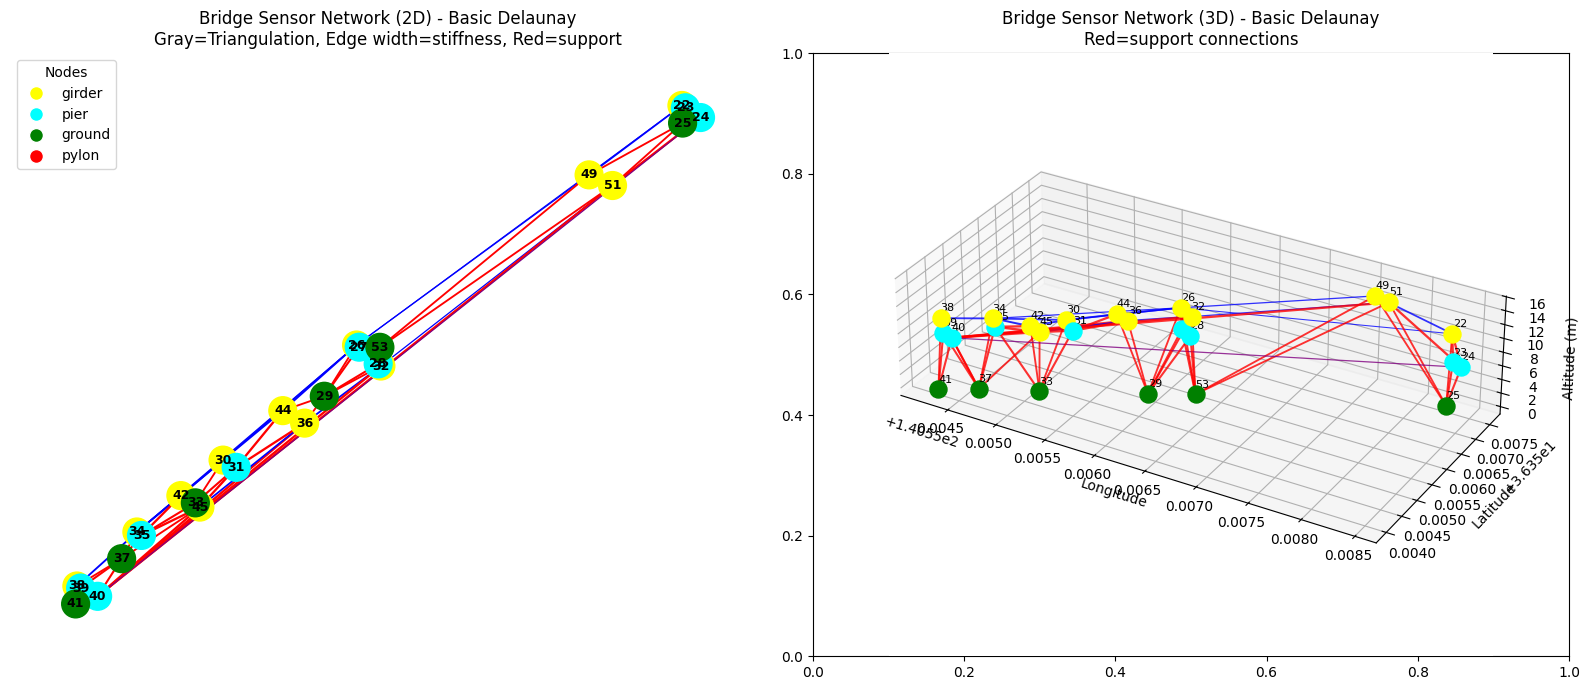


Creating edges with Constrained Delaunay

Creating Delaunay triangulation for 26 sensors...
Coordinate range: X=-147.4 to 219.9m
Coordinate range: Y=-170.8 to 234.9m
Delaunay triangulation created with 43 triangles
Generated 68 unique edges from triangulation

Applying structural engineering constraints...
  support connections: max distance = 70.7m
  girder connections: max distance = 198.3m
  pier connections: max distance = 297.6m
    Filtered out long girder edge: 22-26 (273.1m)
    Filtered out long support edge: 36-40 (186.2m)
    Filtered out long support edge: 32-40 (250.7m)
    Filtered out long support edge: 40-45 (94.3m)
    Filtered out long support edge: 49-53 (187.2m)
    Filtered out long support edge: 40-51 (451.0m)
    Filtered out long pier edge: 24-40 (526.7m)
    Filtered out long girder edge: 32-51 (200.3m)
    Filtered out long support edge: 51-53 (190.4m)
    Filtered out long girder edge: 26-34 (199.6m)
Kept 58 edges after structural filtering

=== Connection A

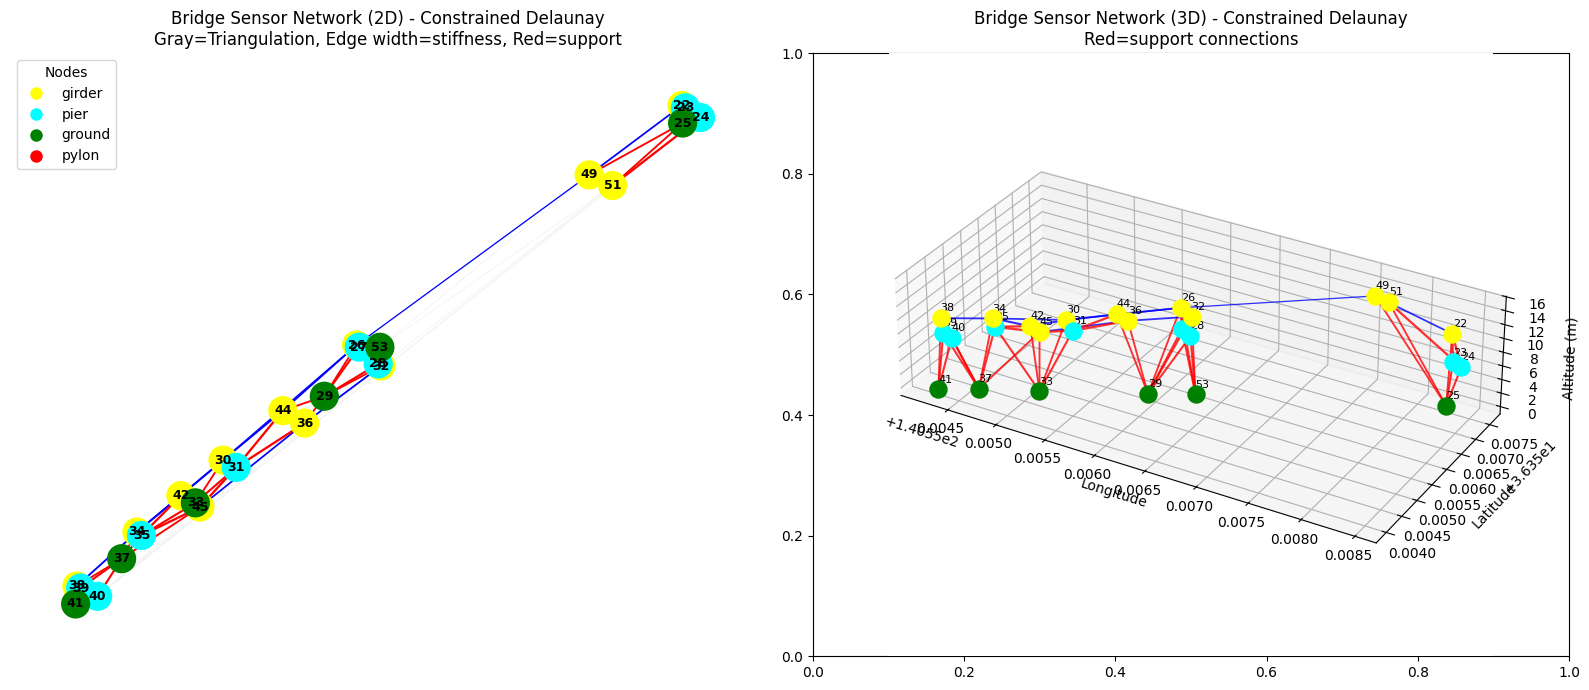


=== Delaunay Triangulation Edge Generation Complete ===
Files generated:
  - bridge_edges_delaunay_basic_delaunay.csv
  - bridge_edges_delaunay_constrained_delaunay.csv

Recommendation: Use Constrained Delaunay for better structural engineering properties
Key advantages of Delaunay:
  - Natural mesh topology
  - Optimal triangulation properties
  - Good connectivity for structural analysis
  - Avoids overly long connections


In [14]:
if __name__ == "__main__":
    # Updated CSV data with correct altitude values
    csv_data = """node_id,type,latitude,longitude,altitude_m
22,girder,36.35760246,140.5582758,10
26,girder,36.35584565,140.5561452,12
30,girder,36.35500155,140.555271,10
32,girder,36.35569158,140.5563046,12
34,girder,36.35447425,140.5547067,10
36,girder,36.35527276,140.5558051,11
38,girder,36.35407821,140.5543137,10
42,girder,36.35474124,140.5549947,9
44,girder,36.35536433,140.5556622,11
45,girder,36.3546569,140.5551193,9
49,girder,36.35709344,140.5576679,15
51,girder,36.35701549,140.5578214,15
23,pier,36.35758548,140.5582983,6
24,pier,36.35751402,140.5583976,6
27,pier,36.35582977,140.5561624,9
28,pier,36.35570737,140.5562867,9
31,pier,36.35494837,140.5553569,9
35,pier,36.35444892,140.5547367,9
39,pier,36.35406326,140.5543382,8
40,pier,36.35400257,140.5544497,8
25,ground,36.3574735,140.5582802,0
29,ground,36.35546989,140.555934,0
33,ground,36.35468793,140.5550896,0
37,ground,36.35427857,140.5546068,0
41,ground,36.35394661,140.5543055,0
53,ground,36.35582872,140.556298,0"""

    # Load data from string
    from io import StringIO
    df = pd.read_csv(StringIO(csv_data))
    
    print("=== Shin-Nakagawa Bridge Sensor Network Analysis (Delaunay Triangulation) ===")
    print("Loaded bridge sensor data:")
    print(df.head())
    print(f"\nTotal sensors: {len(df)}")
    print(f"Sensor types: {df['type'].value_counts().to_dict()}")
    
    print("\n=== Custom Stiffness Values ===")
    print("Pier edges: 1.2")
    print("Girder edges: 1.0")
    print("Pylon edges: 1.5")
    print("Ground edges: 0.8")
    print("Pier-Girder connections: 1.1 (IMPORTANT)")
    print("Pylon-Girder connections: 1.3")
    
    # Create edges using different Delaunay approaches
    methods = [
        ("Basic Delaunay", False),
        ("Constrained Delaunay", True)
    ]
    
    for method_name, use_constraints in methods:
        print(f"\n{'='*60}")
        print(f"Creating edges with {method_name}")
        print(f"{'='*60}")
        
        if use_constraints:
            edges, tri = create_constrained_delaunay_edges(df, structural_constraints=True)
        else:
            edges, tri = create_delaunay_edges(df, filter_long_edges=False)
        
        # Analyze connections
        analyze_connections(df, edges)
        
        # Save edges
        filename = f'bridge_edges_delaunay_{method_name.lower().replace(" ", "_")}.csv'
        save_edges_csv(edges, filename)
        
        # Create and analyze graph
        G = create_networkx_graph(df, edges)
        analyze_graph_properties(G)
        
        # Visualize
        visualize_delaunay_bridge_network(G, df, tri, method=method_name)
    
    print(f"\n{'='*60}")
    print("=== Delaunay Triangulation Edge Generation Complete ===")
    print("Files generated:")
    print("  - bridge_edges_delaunay_basic_delaunay.csv")
    print("  - bridge_edges_delaunay_constrained_delaunay.csv")
    print("\nRecommendation: Use Constrained Delaunay for better structural engineering properties")
    print("Key advantages of Delaunay:")
    print("  - Natural mesh topology")
    print("  - Optimal triangulation properties")  
    print("  - Good connectivity for structural analysis")
    print("  - Avoids overly long connections")